# add some tips

https://medium.com/@utk.is.here/keep-calm-and-train-a-gan-pitfalls-and-tips-on-training-generative-adversarial-networks-edd529764aa9

pro 2-2 : noise uni -> normal

pro 2-1 : n-class at mini batch

In [1]:
import tensorflow as tf
import numpy as np
import os
import sys
import time
import time 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 

os.environ["CUDA_VISIBLE_DEVICES"]="1"

def my_mnist_train_batch(size) :
    m = 500
    data = []
    for i in range(1000) :
        number = number = np.random.randint(5)
        image, label = mnist.train.next_batch(m)       
        for j in range(len(label)) : 
            
            if np.argmax(label[j])==number :
                data.append(image[j])
                number = number = np.random.randint(5)
            if len(data) == size :
                break
        if len(data) == size :
            break
    return data

def my_mnist_test_batch(size, number = 0) :
    m = 500
    data = []
    for i in range(1000) :
        image, label = mnist.test.next_batch(m)       
        for j in range(len(label)) : 
            if np.argmax(label[j])==number :
                data.append(image[j])              
            if len(data) == size :
                break
        if len(data) == size :
            break
    return data

def mnist_4by4_save(samples,path):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)    
    gs.update(wspace=0.05, hspace=0.05) #이미지 사이간격 조절
  
    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')    
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
   
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r',clim=(0.0,1.0))
    plt.colorbar()
    plt.savefig(path, bbox_inches='tight')
    plt.close(fig)
   
    return None

def gan_loss_graph_save(G_loss,D_loss,path):
    x1 = range(len(G_loss))
    x2 = range(len(D_loss))
      
    y1 = G_loss
    y2 = D_loss
  
      
    plt.plot(x1,y1,label='G_loss') 
    plt.plot(x2,y2,label='D_loss') 
  
    plt.xlabel('weight per update')
    plt.ylabel('loss')             
    plt.legend(loc=4)              
    plt.grid(True)
    plt.tight_layout()
  
    plt.savefig(path)              

    return None


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../MNIST_data", one_hot=True)

file_name = 'ex_anoGANs_2'

if not os.path.isdir(file_name) :
    os.mkdir(file_name)
def simple_G(x,isTrain = True, reuse = False, name = 'G_out') : #input = (minibatch * w * h * ch)
    
    # out size = (in size + 2*padding - kenel)/strides + 1    
    w_init = tf.truncated_normal_initializer(mean= 0.0, stddev=0.02)
    b_init = tf.constant_initializer(0.0)


    with tf.variable_scope('G',reuse=reuse) :
        
        #x = (-1, 1, 1, 100)


        conv1 = tf.layers.conv2d_transpose(x,2048,[4,4], strides=(1,1),padding = 'valid',
                kernel_initializer=w_init, bias_initializer=b_init) 
        r1 = tf.nn.elu(tf.layers.batch_normalization(conv1,training=isTrain))#1024*4*4
        
        conv2 = tf.layers.conv2d_transpose(r1,1024,[4,4], strides=(2,2),padding = 'same',
                kernel_initializer=w_init, bias_initializer=b_init)
        r2 = tf.nn.elu(tf.layers.batch_normalization(conv2,training=isTrain))#512*8*8
                
        conv3 = tf.layers.conv2d_transpose(r2,512,[4,4], strides=(2,2),padding = 'same',
                kernel_initializer=w_init, bias_initializer=b_init)
        r3 = tf.nn.elu(tf.layers.batch_normalization(conv3,training=isTrain))#256*16*16

        conv4 = tf.layers.conv2d_transpose(r3,256,[4,4], strides=(2,2),padding = 'same',
                kernel_initializer=w_init, bias_initializer=b_init)
        r4 = tf.nn.elu(tf.layers.batch_normalization(conv4,training=isTrain))#128*32*32

        conv5 = tf.layers.conv2d(r4,128,[3,3], strides=(1,1),padding = 'valid',
                kernel_initializer=w_init, bias_initializer=b_init)
        r5 = tf.nn.elu(tf.layers.batch_normalization(conv5,training=isTrain))#64*30*30

        conv6 = tf.layers.conv2d(r5,1,[3,3], strides=(1,1),padding = 'valid',
                kernel_initializer=w_init, bias_initializer=b_init)
    r6 = tf.nn.sigmoid(conv6,name=name)#1*28*28
  

    return r6
def residual_loss_G(x,isTrain = False, reuse = True, name = 'residual_loss_out') : #input = (minibatch * w * h * ch)
    
    # out size = (in size + 2*padding - kenel)/strides + 1    


    with tf.variable_scope('G',reuse=reuse) as scope :
        scope.reuse_variables()
        #x = (-1, 1, 1, 100)


        conv1 = tf.layers.conv2d_transpose(x,2048,[4,4], strides=(1,1),padding = 'valid')
        r1 = tf.nn.elu(tf.layers.batch_normalization(conv1,training=isTrain))#1024*4*4
        
        conv2 = tf.layers.conv2d_transpose(r1,1024,[4,4], strides=(2,2),padding = 'same')
        r2 = tf.nn.elu(tf.layers.batch_normalization(conv2,training=isTrain))#512*8*8
                
        conv3 = tf.layers.conv2d_transpose(r2,512,[4,4], strides=(2,2),padding = 'same')
        r3 = tf.nn.elu(tf.layers.batch_normalization(conv3,training=isTrain))#256*16*16

        conv4 = tf.layers.conv2d_transpose(r3,256,[4,4], strides=(2,2),padding = 'same')
        r4 = tf.nn.elu(tf.layers.batch_normalization(conv4,training=isTrain))#128*32*32

        conv5 = tf.layers.conv2d(r4,128,[3,3], strides=(1,1),padding = 'valid')
        r5 = tf.nn.elu(tf.layers.batch_normalization(conv5,training=isTrain))#64*30*30

        conv6 = tf.layers.conv2d(r5,1,[3,3], strides=(1,1),padding = 'valid')
    r6 = tf.nn.sigmoid(conv6,name=name)#1*28*28
  

    return r6
def simple_D(x,isTrain=True,reuse = False) :
    
    w_init = tf.truncated_normal_initializer(mean= 0.0, stddev=0.02)
    b_init = tf.constant_initializer(0.0)
    with tf.variable_scope('D', reuse=reuse) :
        
        #x = (-1,28,28,1)
        # out size = (in size + 2*padding - kenel)/strides + 1   

        conv1 = tf.layers.conv2d(x,128,[5,5], strides=(1,1),padding = 'valid',
                                kernel_initializer=w_init, bias_initializer=b_init) 
        r1 = tf.nn.elu(tf.layers.batch_normalization(conv1,training=isTrain))#64*24*24

   
        conv2 = tf.layers.conv2d(r1,256,[5,5], strides=(1,1),padding = 'valid',
                                kernel_initializer=w_init, bias_initializer=b_init)
        r2 = tf.nn.elu(tf.layers.batch_normalization(conv2,training=isTrain))#128*20*20

  
        conv3 = tf.layers.conv2d(r2,512,[5,5], strides=(1,1),padding = 'valid',
                                kernel_initializer=w_init, bias_initializer=b_init)
        r3 = tf.nn.elu(tf.layers.batch_normalization(conv3,training=isTrain))#256*16*16

 
        conv4 = tf.layers.conv2d(r3,1024,[4,4], strides=(2,2),padding = 'same',
                                kernel_initializer=w_init, bias_initializer=b_init)
        r4 = tf.nn.elu(tf.layers.batch_normalization(conv4,training=isTrain))#512*8*8


        conv5 = tf.layers.conv2d(r4,2048,[4,4], strides=(2,2),padding = 'same',
                                kernel_initializer=w_init, bias_initializer=b_init)
        r5 = tf.nn.elu(tf.layers.batch_normalization(conv5,training=isTrain))#1024*4*4

       
        conv6 = tf.layers.conv2d(r5,1,[4,4], strides=(1,1),padding = 'valid',
                                kernel_initializer=w_init, bias_initializer=b_init)
    r6 = tf.nn.sigmoid(conv6)#1*1*1


    return r6
def feature_extractor_D(x,isTrain=False,reuse = True, name='feature_out') :
    
    with tf.variable_scope('D', reuse=reuse) as scope :
        scope.reuse_variables()
        #x = (-1,28,28,1)

        conv1 = tf.layers.conv2d(x,128,[5,5], strides=(1,1),padding = 'valid')
        r1 = tf.nn.elu(tf.layers.batch_normalization(conv1,training=isTrain))#64*24*24

   
        conv2 = tf.layers.conv2d(r1,256,[5,5], strides=(1,1),padding = 'valid')
        r2 = tf.nn.elu(tf.layers.batch_normalization(conv2,training=isTrain))#128*20*20

  
        conv3 = tf.layers.conv2d(r2,512,[5,5], strides=(1,1),padding = 'valid')
    r3 = tf.nn.elu(tf.layers.batch_normalization(conv3,training=isTrain),name = name)#256*16*16

 
        #conv4 = tf.layers.conv2d(r3,1024,[4,4], strides=(2,2),padding = 'same')
        #r4 = tf.nn.lrelu(tf.layers.batch_normalization(conv4,training=isTrain),0.2)#512*8*8


        #conv5 = tf.layers.conv2d(r4,2048,[4,4], strides=(2,2),padding = 'same')
        #r5 = tf.nn.lrelu(tf.layers.batch_normalization(conv5,training=isTrain),0.2)#1024*4*4


    return r3



Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
lr = 0.001
ramda = 0.1

z_size = 100

z = tf.placeholder(tf.float32,shape=(None,1,1,z_size),name = 'z')    
u = tf.placeholder(tf.float32, shape = (None, 28,28,1),name='u')
ano_y = tf.placeholder(tf.float32, shape = (1, 28,28,1),name='ano_y')

ano_z = tf.get_variable('ano_z', shape = [1, 1, 1, z_size], dtype = tf.float32, 
        initializer = tf.truncated_normal_initializer(mean= 0.0, stddev=0.1))

isTrain = tf.placeholder(dtype=tf.bool,name='isTrain') 
soft_one = tf.placeholder(tf.float32, shape = (None, 1,1,1),name='soft_one') # 0.9~1.0
soft_zero = tf.placeholder(tf.float32, shape = (None, 1,1,1),name='soft_zero') # 0.0~0.1

G_z = simple_G(z,name='G_z')

D_real = simple_D(u,isTrain)
D_fake = simple_D(G_z,isTrain,reuse=True)


img_z = residual_loss_G(ano_z, name ='img_z')
img_z_result= simple_D(img_z,isTrain=False,reuse=True)

feature_y = feature_extractor_D(ano_y, reuse = True, name ='feature_y')
feature_z = feature_extractor_D(img_z, reuse = True, name ='feature_z')


#feature_loss = tf.reduce_mean(tf.abs(feature_y-feature_z),name = 'feature_loss')
D_real_loss = tf.reduce_mean(-(soft_one*tf.log(D_real + 1e-8) + (1-soft_one)*tf.log(1- D_real + 1e-8)),name = 'D_real_loss')
D_fake_loss = tf.reduce_mean(-(soft_zero*tf.log(D_fake + 1e-8) + (1-soft_zero)*tf.log(1 - D_fake + 1e-8)),name = 'D_fake_loss')


D_loss =  tf.add(D_real_loss,D_fake_loss,name='D_loss')
G_loss =  tf.reduce_mean(-tf.log(D_fake + 1e-8),name='G_loss')
residual_loss = tf.reduce_mean(tf.abs(img_z - ano_y), name = 'residual_loss')
discrimination_loss = tf.reduce_mean(-tf.log(img_z_result + 1e-8),name = 'discrimination_loss')


mapping_loss = tf.add((1-ramda)*residual_loss,  ramda*discrimination_loss,name = 'mapping_loss') 

T_vars = tf.trainable_variables()
D_vars = [var for var in T_vars if var.name.startswith('D')]
G_vars = [var for var in T_vars if var.name.startswith('G')]
ano_vars = [var for var in T_vars if var.name.startswith('ano')]
    # When using the batchnormalization layers,
    # it is necessary to manually add the update operations
    # because the moving averages are not included in the graph

with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)) :        
    D_optim = tf.train.AdamOptimizer(0.001,beta1=0.5).minimize(D_loss, var_list=D_vars, name='D_optim') 
    G_optim = tf.train.AdamOptimizer(0.001,beta1=0.5).minimize(G_loss, var_list=G_vars, name='G_optim')
    
mapping_optim = tf.train.AdamOptimizer(0.001,beta1=0.5).minimize(mapping_loss, var_list=ano_vars, name='mapping_optim')



D_e : 2.948978, D_real_e : 1.604239, D_fake_e : 1.344739, G_e : 16.856833
D_e : 10.048728, D_real_e : 3.934374, D_fake_e : 6.185351, G_e : 10.265368
D_e : 7.118348, D_real_e : 2.268212, D_fake_e : 1.890450, G_e : 7.711178
D_e : 5.735427, D_real_e : 1.530844, D_fake_e : 1.424916, G_e : 5.984812
D_e : 4.907207, D_real_e : 1.231564, D_fake_e : 1.182698, G_e : 4.991976
D_e : 4.364913, D_real_e : 1.130107, D_fake_e : 1.060207, G_e : 4.363600
D_e : 3.977821, D_real_e : 1.029871, D_fake_e : 1.008618, G_e : 3.927269
D_e : 3.701242, D_real_e : 1.025758, D_fake_e : 1.013246, G_e : 3.624521
D_e : 3.482476, D_real_e : 0.980386, D_fake_e : 0.968534, G_e : 3.388964
D_e : 3.296840, D_real_e : 0.926784, D_fake_e : 0.883119, G_e : 3.205159
D_e : 3.156806, D_real_e : 0.958048, D_fake_e : 0.937051, G_e : 3.068679
D_e : 3.018179, D_real_e : 0.825641, D_fake_e : 0.804880, G_e : 2.950272
D_e : 2.908093, D_real_e : 0.860780, D_fake_e : 0.835271, G_e : 2.849864
D_e : 2.813614, D_real_e : 0.853361, D_fake_e : 

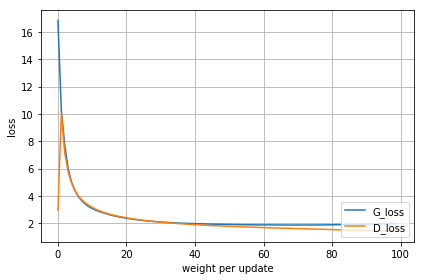

In [4]:
with tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))) as sess :
    sess.run(tf.global_variables_initializer())

    np.random.seed(int(time.time()))

    test_z = np.random.normal(0,1,size=(16,1,1,z_size))

    
    log_txt = open(file_name +'/log.txt','w')

    hist_G = []
    hist_D = []
    G_error = []
    D_error = []
    D_fake_error = []
    D_real_error = []
    
    start = time.time()
    for i in range(10000) :
        
        train_images = my_mnist_train_batch(100) 
        u_ = np.reshape(train_images,(-1,28,28,1)) 
        z_ = np.random.normal(0,1,size=(100,1,1,z_size))
        soft_one_ = np.random.uniform(0.9,1.0,(100,1,1,1))
        soft_zero_ = np.random.uniform(0.0,0.1,(100,1,1,1))
        
        _ , D_e,D_real_e,D_fake_e = sess.run([D_optim, D_loss,D_real_loss,D_fake_loss], {u : u_, z : z_, isTrain : True,
                                                                                         soft_one : soft_one_, soft_zero : soft_zero_})
        D_error.append(D_e)
        D_real_error.append(D_real_e)
        D_fake_error.append(D_fake_e)


    #    train_images,train_labels = mnist.train.next_batch(100)    
    #    u_ = np.reshape(train_images,(-1,28,28,1)) 
    #    z_ = np.random.normal(0,1,size=(100,1,1,100))
   
        _ , G_e = sess.run([G_optim, G_loss], {u : u_, z : z_, isTrain : True}) 
        G_error.append(G_e)
        
        if i%100 == 0:

            hist_D.append(np.mean(D_error)) 
            hist_G.append(np.mean(G_error))

            print('D_e : %.6f, D_real_e : %.6f, D_fake_e : %.6f, G_e : %.6f'%(np.mean(D_error), np.mean(D_real_error),
                np.mean(D_fake_error), np.mean(G_error)))
            log_txt.write('D_e : %.6f, D_real_e : %.6f, D_fake_e : %.6f, G_e : %.6f\n'%(np.mean(D_error),
                np.mean(D_real_error), np.mean(D_fake_error), np.mean(G_error)))
      
            r = sess.run([G_z],feed_dict={z : test_z, isTrain : False})        
            mnist_4by4_save(np.reshape(r,(-1,784)),file_name + '/result_{}.png'.format(str(i).zfill(3)))

            np.random.seed(int(time.time()))

            G_errer = []
            D_errer = []
            D_fake_error = []
            D_real_error = []


    log_txt.close()
    gan_loss_graph_save(G_loss = hist_G,D_loss=hist_D,path = file_name + '/loss_graph.png')   
    saver = tf.train.Saver()
    saver.save(sess,file_name + '/para.cktp')

    end = time.time()-start

    print("total time : ",end)

In [5]:


if not os.path.isdir(file_name) :
    os.mkdir(file_name)

    
sess = tf.InteractiveSession()
    
new_saver = tf.train.import_meta_graph(file_name + '/para.cktp.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(file_name + '/'))


z = sess.graph.get_tensor_by_name("z:0")
u = sess.graph.get_tensor_by_name("u:0")

ano_y = sess.graph.get_tensor_by_name("ano_y:0")
ano_z = sess.graph.get_tensor_by_name("ano_z:0")

isTrain = sess.graph.get_tensor_by_name("isTrain:0")

    
G_z = sess.graph.get_tensor_by_name("G_z:0")
img_z = sess.graph.get_tensor_by_name("img_z:0")


#feature_loss = sess.graph.get_tensor_by_name("feature_loss:0")
D_real_loss = sess.graph.get_tensor_by_name('D_real_loss:0')
D_fake_loss = sess.graph.get_tensor_by_name('D_fake_loss:0')

D_loss = sess.graph.get_tensor_by_name("D_loss:0")
G_loss = sess.graph.get_tensor_by_name("G_loss:0")
residual_loss = sess.graph.get_tensor_by_name("residual_loss:0")
discrimination_loss = sess.graph.get_tensor_by_name("discrimination_loss:0")

D_optim = sess.graph.get_operation_by_name("D_optim")
G_optim = sess.graph.get_operation_by_name("G_optim")

mapping_optim = sess.graph.get_operation_by_name("mapping_optim")





INFO:tensorflow:Restoring parameters from ex_anoGANs_2/para.cktp


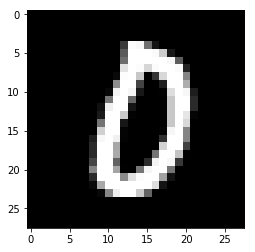

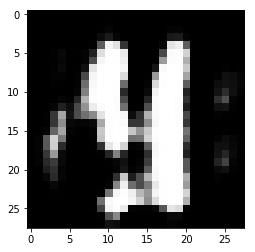

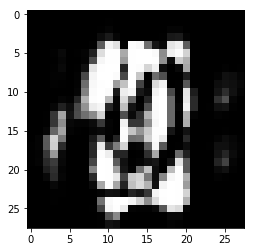

0.0715634 0.198814
0.198814 0.0715634
0.11098 0.0168518
0.0773553 0.0186378
0.0627737 0.0326422
0.059136 0.0232461
0.0554436 0.032551
0.053886 0.0323355
0.0528366 0.0299781
0.0515706 0.0309129
0.0503969 0.0313162


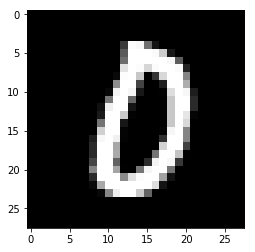

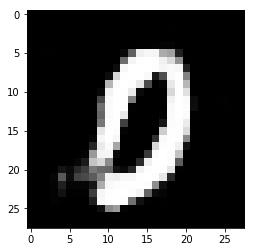

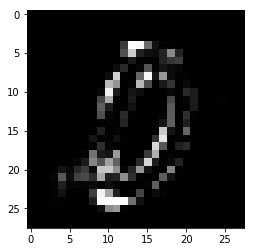

0.0302745 0.0495776


In [6]:
im = my_mnist_test_batch(1, number = 0) 
plt.imshow(np.reshape(im,(28, 28)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([img_z]) 
plt.imshow(np.reshape(im_fake,(28, 28)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(28, 28)) - np.reshape(im,(28, 28)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

fea_loss, res_loss = sess.run([discrimination_loss,residual_loss], {ano_y : np.reshape(im,(1,28, 28,1))})

print(fea_loss, res_loss)


for i in range(1000) :
    _ , loss1, loss2 = sess.run([mapping_optim,residual_loss,discrimination_loss], {ano_y : np.reshape(im,(1,28, 28,1))})
    if  i % 100 == 0 : 
        print(loss1,loss2)
        
        
plt.imshow(np.reshape(im,(28, 28)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([img_z]) 
plt.imshow(np.reshape(im_fake,(28, 28)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(28, 28)) - np.reshape(im,(28, 28)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

fea_loss, res_loss = sess.run([discrimination_loss,residual_loss], {ano_y : np.reshape(im,(1,28, 28,1))})

print(fea_loss, res_loss)

In [3]:


if not os.path.isdir(file_name) :
    os.mkdir(file_name)

    
sess = tf.InteractiveSession()
    
new_saver = tf.train.import_meta_graph(file_name + '/para.cktp.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(file_name + '/'))


z = sess.graph.get_tensor_by_name("z:0")
u = sess.graph.get_tensor_by_name("u:0")

ano_y = sess.graph.get_tensor_by_name("ano_y:0")
ano_z = sess.graph.get_tensor_by_name("ano_z:0")

isTrain = sess.graph.get_tensor_by_name("isTrain:0")

    
G_z = sess.graph.get_tensor_by_name("G_z:0")
img_z = sess.graph.get_tensor_by_name("img_z:0")


#feature_loss = sess.graph.get_tensor_by_name("feature_loss:0")
D_real_loss = sess.graph.get_tensor_by_name('D_real_loss:0')
D_fake_loss = sess.graph.get_tensor_by_name('D_fake_loss:0')

D_loss = sess.graph.get_tensor_by_name("D_loss:0")
G_loss = sess.graph.get_tensor_by_name("G_loss:0")
residual_loss = sess.graph.get_tensor_by_name("residual_loss:0")
discrimination_loss = sess.graph.get_tensor_by_name("discrimination_loss:0")

D_optim = sess.graph.get_operation_by_name("D_optim")
G_optim = sess.graph.get_operation_by_name("G_optim")

mapping_optim = sess.graph.get_operation_by_name("mapping_optim")






INFO:tensorflow:Restoring parameters from ex_anoGANs_2/para.cktp


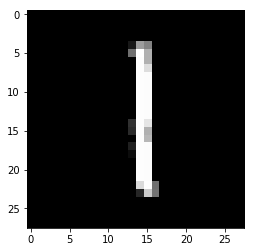

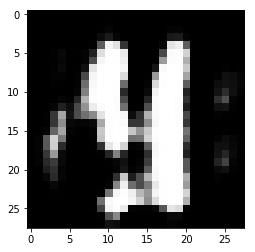

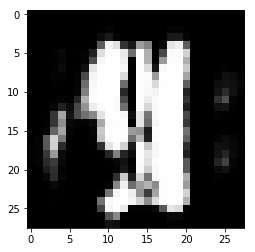

0.0715634 0.25165
0.25165 0.0715632
0.117205 0.0552859
0.0908491 0.0642743
0.0766305 0.0679479
0.0668987 0.0756368
0.0607535 0.083753
0.0515543 0.106125
0.0490544 0.0920907
0.0460478 0.0919538
0.0427048 0.0972319


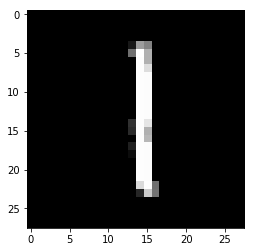

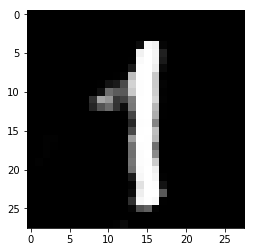

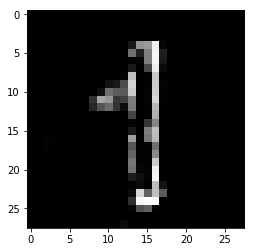

0.0816181 0.0412997


In [4]:
im = my_mnist_test_batch(1, number = 1) 
plt.imshow(np.reshape(im,(28, 28)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([img_z]) 
plt.imshow(np.reshape(im_fake,(28, 28)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(28, 28)) - np.reshape(im,(28, 28)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

fea_loss, res_loss = sess.run([discrimination_loss,residual_loss], {ano_y : np.reshape(im,(1,28, 28,1))})

print(fea_loss, res_loss)


for i in range(1000) :
    _ , loss1, loss2 = sess.run([mapping_optim,residual_loss,discrimination_loss], {ano_y : np.reshape(im,(1,28, 28,1))})
    if  i % 100 == 0 : 
        print(loss1,loss2)
        
        
plt.imshow(np.reshape(im,(28, 28)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([img_z]) 
plt.imshow(np.reshape(im_fake,(28, 28)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(28, 28)) - np.reshape(im,(28, 28)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

fea_loss, res_loss = sess.run([discrimination_loss,residual_loss], {ano_y : np.reshape(im,(1,28, 28,1))})

print(fea_loss, res_loss)

In [5]:


if not os.path.isdir(file_name) :
    os.mkdir(file_name)

    
sess = tf.InteractiveSession()
    
new_saver = tf.train.import_meta_graph(file_name + '/para.cktp.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(file_name + '/'))


z = sess.graph.get_tensor_by_name("z:0")
u = sess.graph.get_tensor_by_name("u:0")

ano_y = sess.graph.get_tensor_by_name("ano_y:0")
ano_z = sess.graph.get_tensor_by_name("ano_z:0")

isTrain = sess.graph.get_tensor_by_name("isTrain:0")

    
G_z = sess.graph.get_tensor_by_name("G_z:0")
img_z = sess.graph.get_tensor_by_name("img_z:0")


#feature_loss = sess.graph.get_tensor_by_name("feature_loss:0")
D_real_loss = sess.graph.get_tensor_by_name('D_real_loss:0')
D_fake_loss = sess.graph.get_tensor_by_name('D_fake_loss:0')

D_loss = sess.graph.get_tensor_by_name("D_loss:0")
G_loss = sess.graph.get_tensor_by_name("G_loss:0")
residual_loss = sess.graph.get_tensor_by_name("residual_loss:0")
discrimination_loss = sess.graph.get_tensor_by_name("discrimination_loss:0")

D_optim = sess.graph.get_operation_by_name("D_optim")
G_optim = sess.graph.get_operation_by_name("G_optim")

mapping_optim = sess.graph.get_operation_by_name("mapping_optim")






INFO:tensorflow:Restoring parameters from ex_anoGANs_2/para.cktp


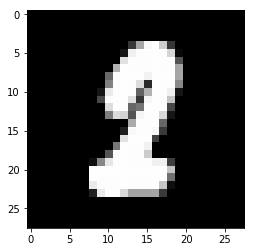

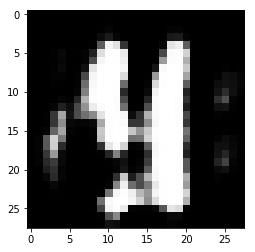

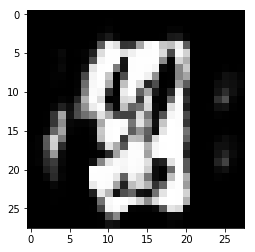

0.0715632 0.232018
0.232018 0.0715635
0.118601 0.0607116
0.09688 0.0409501
0.0898324 0.038777
0.0853665 0.0357532
0.0815632 0.0324679
0.0778446 0.0273513
0.0738864 0.025072
0.0652226 0.0280883
0.0601541 0.0247869


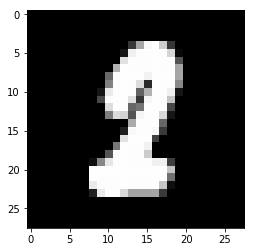

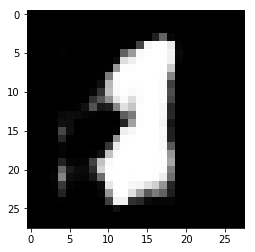

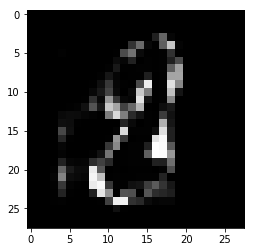

0.0193343 0.0556992


In [6]:
im = my_mnist_test_batch(1, number = 2) 
plt.imshow(np.reshape(im,(28, 28)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([img_z]) 
plt.imshow(np.reshape(im_fake,(28, 28)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(28, 28)) - np.reshape(im,(28, 28)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

fea_loss, res_loss = sess.run([discrimination_loss,residual_loss], {ano_y : np.reshape(im,(1,28, 28,1))})

print(fea_loss, res_loss)


for i in range(1000) :
    _ , loss1, loss2 = sess.run([mapping_optim,residual_loss,discrimination_loss], {ano_y : np.reshape(im,(1,28, 28,1))})
    if  i % 100 == 0 : 
        print(loss1,loss2)
        
        
plt.imshow(np.reshape(im,(28, 28)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([img_z]) 
plt.imshow(np.reshape(im_fake,(28, 28)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(28, 28)) - np.reshape(im,(28, 28)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

fea_loss, res_loss = sess.run([discrimination_loss,residual_loss], {ano_y : np.reshape(im,(1,28, 28,1))})

print(fea_loss, res_loss)

In [7]:


if not os.path.isdir(file_name) :
    os.mkdir(file_name)

    
sess = tf.InteractiveSession()
    
new_saver = tf.train.import_meta_graph(file_name + '/para.cktp.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(file_name + '/'))


z = sess.graph.get_tensor_by_name("z:0")
u = sess.graph.get_tensor_by_name("u:0")

ano_y = sess.graph.get_tensor_by_name("ano_y:0")
ano_z = sess.graph.get_tensor_by_name("ano_z:0")

isTrain = sess.graph.get_tensor_by_name("isTrain:0")

    
G_z = sess.graph.get_tensor_by_name("G_z:0")
img_z = sess.graph.get_tensor_by_name("img_z:0")


#feature_loss = sess.graph.get_tensor_by_name("feature_loss:0")
D_real_loss = sess.graph.get_tensor_by_name('D_real_loss:0')
D_fake_loss = sess.graph.get_tensor_by_name('D_fake_loss:0')

D_loss = sess.graph.get_tensor_by_name("D_loss:0")
G_loss = sess.graph.get_tensor_by_name("G_loss:0")
residual_loss = sess.graph.get_tensor_by_name("residual_loss:0")
discrimination_loss = sess.graph.get_tensor_by_name("discrimination_loss:0")

D_optim = sess.graph.get_operation_by_name("D_optim")
G_optim = sess.graph.get_operation_by_name("G_optim")

mapping_optim = sess.graph.get_operation_by_name("mapping_optim")






INFO:tensorflow:Restoring parameters from ex_anoGANs_2/para.cktp


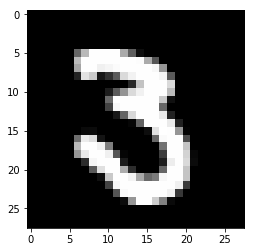

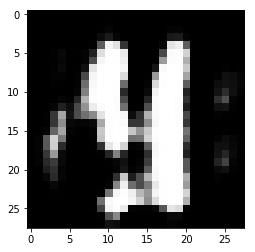

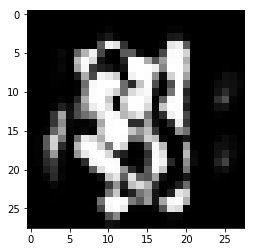

0.0715635 0.206908
0.206908 0.0715632
0.12057 0.0625224
0.107903 0.0422106
0.0954595 0.0426421
0.0863257 0.0451409
0.081417 0.0412605
0.0782926 0.0387308
0.0756537 0.0382282
0.0746287 0.0326924
0.0721049 0.0362561


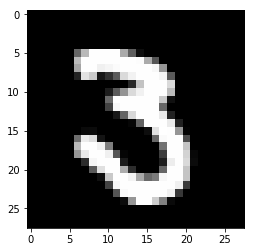

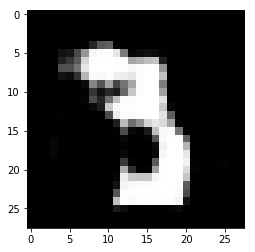

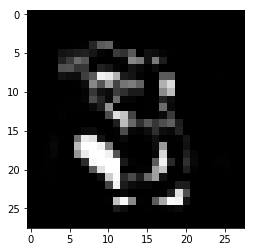

0.0287835 0.070863


In [8]:
im = my_mnist_test_batch(1, number = 3) 
plt.imshow(np.reshape(im,(28, 28)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([img_z]) 
plt.imshow(np.reshape(im_fake,(28, 28)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(28, 28)) - np.reshape(im,(28, 28)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

fea_loss, res_loss = sess.run([discrimination_loss,residual_loss], {ano_y : np.reshape(im,(1,28, 28,1))})

print(fea_loss, res_loss)


for i in range(1000) :
    _ , loss1, loss2 = sess.run([mapping_optim,residual_loss,discrimination_loss], {ano_y : np.reshape(im,(1,28, 28,1))})
    if  i % 100 == 0 : 
        print(loss1,loss2)
        
        
plt.imshow(np.reshape(im,(28, 28)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([img_z]) 
plt.imshow(np.reshape(im_fake,(28, 28)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(28, 28)) - np.reshape(im,(28, 28)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

fea_loss, res_loss = sess.run([discrimination_loss,residual_loss], {ano_y : np.reshape(im,(1,28, 28,1))})

print(fea_loss, res_loss)

In [9]:


if not os.path.isdir(file_name) :
    os.mkdir(file_name)

    
sess = tf.InteractiveSession()
    
new_saver = tf.train.import_meta_graph(file_name + '/para.cktp.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(file_name + '/'))


z = sess.graph.get_tensor_by_name("z:0")
u = sess.graph.get_tensor_by_name("u:0")

ano_y = sess.graph.get_tensor_by_name("ano_y:0")
ano_z = sess.graph.get_tensor_by_name("ano_z:0")

isTrain = sess.graph.get_tensor_by_name("isTrain:0")

    
G_z = sess.graph.get_tensor_by_name("G_z:0")
img_z = sess.graph.get_tensor_by_name("img_z:0")


#feature_loss = sess.graph.get_tensor_by_name("feature_loss:0")
D_real_loss = sess.graph.get_tensor_by_name('D_real_loss:0')
D_fake_loss = sess.graph.get_tensor_by_name('D_fake_loss:0')

D_loss = sess.graph.get_tensor_by_name("D_loss:0")
G_loss = sess.graph.get_tensor_by_name("G_loss:0")
residual_loss = sess.graph.get_tensor_by_name("residual_loss:0")
discrimination_loss = sess.graph.get_tensor_by_name("discrimination_loss:0")

D_optim = sess.graph.get_operation_by_name("D_optim")
G_optim = sess.graph.get_operation_by_name("G_optim")

mapping_optim = sess.graph.get_operation_by_name("mapping_optim")






INFO:tensorflow:Restoring parameters from ex_anoGANs_2/para.cktp


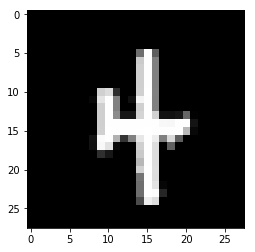

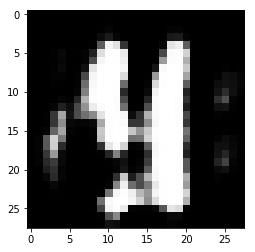

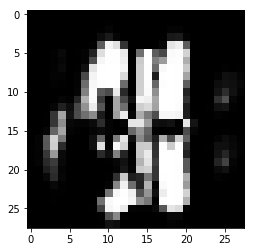

0.0715635 0.201253
0.201253 0.0715635
0.0965116 0.0316625
0.0723132 0.0218716
0.0604425 0.0187624
0.0527081 0.0191324
0.0492161 0.0152962
0.0477024 0.0137382
0.0456893 0.0180398
0.0452624 0.0145519
0.0442217 0.0155432


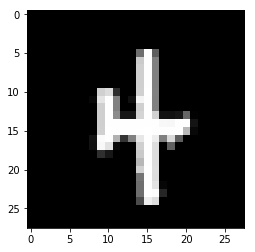

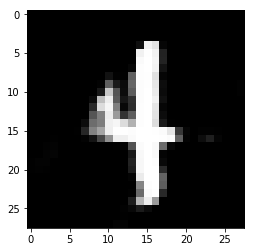

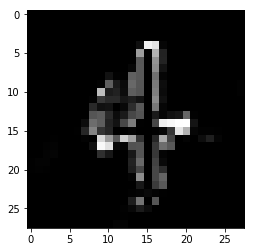

0.0187133 0.0431513


In [10]:
im = my_mnist_test_batch(1, number = 4) 
plt.imshow(np.reshape(im,(28, 28)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([img_z]) 
plt.imshow(np.reshape(im_fake,(28, 28)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(28, 28)) - np.reshape(im,(28, 28)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

fea_loss, res_loss = sess.run([discrimination_loss,residual_loss], {ano_y : np.reshape(im,(1,28, 28,1))})

print(fea_loss, res_loss)


for i in range(1000) :
    _ , loss1, loss2 = sess.run([mapping_optim,residual_loss,discrimination_loss], {ano_y : np.reshape(im,(1,28, 28,1))})
    if  i % 100 == 0 : 
        print(loss1,loss2)
        
        
plt.imshow(np.reshape(im,(28, 28)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([img_z]) 
plt.imshow(np.reshape(im_fake,(28, 28)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(28, 28)) - np.reshape(im,(28, 28)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

fea_loss, res_loss = sess.run([discrimination_loss,residual_loss], {ano_y : np.reshape(im,(1,28, 28,1))})

print(fea_loss, res_loss)

In [11]:


if not os.path.isdir(file_name) :
    os.mkdir(file_name)

    
sess = tf.InteractiveSession()
    
new_saver = tf.train.import_meta_graph(file_name + '/para.cktp.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(file_name + '/'))


z = sess.graph.get_tensor_by_name("z:0")
u = sess.graph.get_tensor_by_name("u:0")

ano_y = sess.graph.get_tensor_by_name("ano_y:0")
ano_z = sess.graph.get_tensor_by_name("ano_z:0")

isTrain = sess.graph.get_tensor_by_name("isTrain:0")

    
G_z = sess.graph.get_tensor_by_name("G_z:0")
img_z = sess.graph.get_tensor_by_name("img_z:0")


#feature_loss = sess.graph.get_tensor_by_name("feature_loss:0")
D_real_loss = sess.graph.get_tensor_by_name('D_real_loss:0')
D_fake_loss = sess.graph.get_tensor_by_name('D_fake_loss:0')

D_loss = sess.graph.get_tensor_by_name("D_loss:0")
G_loss = sess.graph.get_tensor_by_name("G_loss:0")
residual_loss = sess.graph.get_tensor_by_name("residual_loss:0")
discrimination_loss = sess.graph.get_tensor_by_name("discrimination_loss:0")

D_optim = sess.graph.get_operation_by_name("D_optim")
G_optim = sess.graph.get_operation_by_name("G_optim")

mapping_optim = sess.graph.get_operation_by_name("mapping_optim")






INFO:tensorflow:Restoring parameters from ex_anoGANs_2/para.cktp


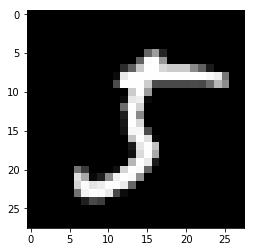

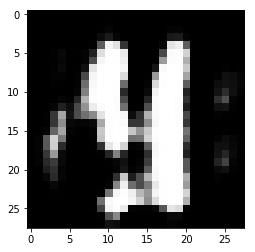

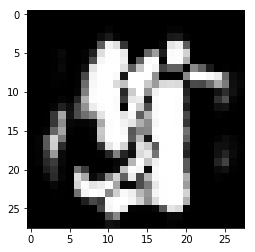

0.0715631 0.264973
0.264973 0.0715632
0.148739 0.0333065
0.132664 0.0312907
0.124206 0.0360103
0.11628 0.038589
0.111769 0.0334765
0.106332 0.0476765
0.100804 0.0540206
0.0959036 0.0506237
0.0942046 0.0424346


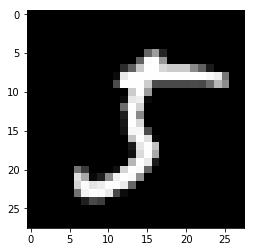

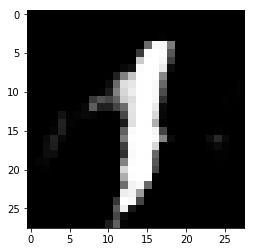

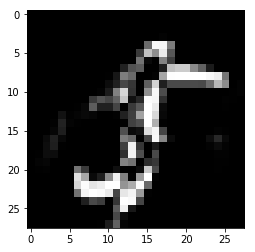

0.0367823 0.0929004


In [12]:
im = my_mnist_test_batch(1, number = 5) 
plt.imshow(np.reshape(im,(28, 28)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([img_z]) 
plt.imshow(np.reshape(im_fake,(28, 28)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(28, 28)) - np.reshape(im,(28, 28)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

fea_loss, res_loss = sess.run([discrimination_loss,residual_loss], {ano_y : np.reshape(im,(1,28, 28,1))})

print(fea_loss, res_loss)


for i in range(1000) :
    _ , loss1, loss2 = sess.run([mapping_optim,residual_loss,discrimination_loss], {ano_y : np.reshape(im,(1,28, 28,1))})
    if  i % 100 == 0 : 
        print(loss1,loss2)
        
        
plt.imshow(np.reshape(im,(28, 28)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([img_z]) 
plt.imshow(np.reshape(im_fake,(28, 28)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(28, 28)) - np.reshape(im,(28, 28)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

fea_loss, res_loss = sess.run([discrimination_loss,residual_loss], {ano_y : np.reshape(im,(1,28, 28,1))})

print(fea_loss, res_loss)

In [13]:


if not os.path.isdir(file_name) :
    os.mkdir(file_name)

    
sess = tf.InteractiveSession()
    
new_saver = tf.train.import_meta_graph(file_name + '/para.cktp.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(file_name + '/'))


z = sess.graph.get_tensor_by_name("z:0")
u = sess.graph.get_tensor_by_name("u:0")

ano_y = sess.graph.get_tensor_by_name("ano_y:0")
ano_z = sess.graph.get_tensor_by_name("ano_z:0")

isTrain = sess.graph.get_tensor_by_name("isTrain:0")

    
G_z = sess.graph.get_tensor_by_name("G_z:0")
img_z = sess.graph.get_tensor_by_name("img_z:0")


#feature_loss = sess.graph.get_tensor_by_name("feature_loss:0")
D_real_loss = sess.graph.get_tensor_by_name('D_real_loss:0')
D_fake_loss = sess.graph.get_tensor_by_name('D_fake_loss:0')

D_loss = sess.graph.get_tensor_by_name("D_loss:0")
G_loss = sess.graph.get_tensor_by_name("G_loss:0")
residual_loss = sess.graph.get_tensor_by_name("residual_loss:0")
discrimination_loss = sess.graph.get_tensor_by_name("discrimination_loss:0")

D_optim = sess.graph.get_operation_by_name("D_optim")
G_optim = sess.graph.get_operation_by_name("G_optim")

mapping_optim = sess.graph.get_operation_by_name("mapping_optim")






INFO:tensorflow:Restoring parameters from ex_anoGANs_2/para.cktp


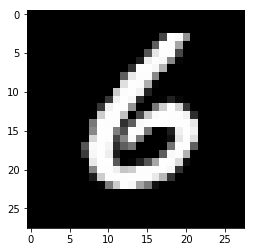

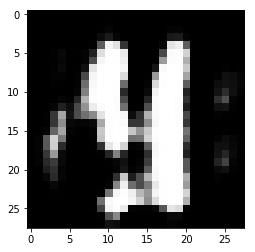

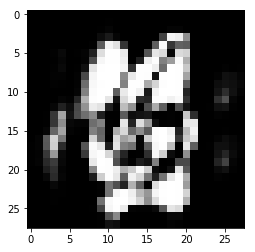

0.0715635 0.225322
0.225322 0.0715635
0.145403 0.0218112
0.122463 0.0149415
0.117846 0.0120588
0.114751 0.0114568
0.112133 0.0116956
0.108676 0.0154898
0.092725 0.0145579
0.0864263 0.0157323
0.0783889 0.00507837


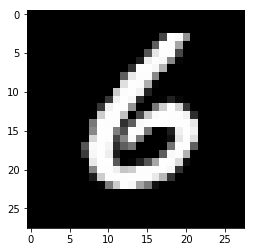

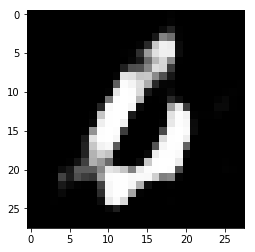

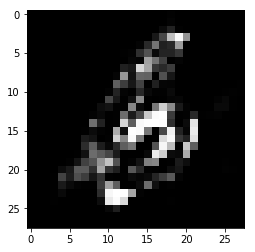

0.00845876 0.0732998


In [14]:
im = my_mnist_test_batch(1, number = 6) 
plt.imshow(np.reshape(im,(28, 28)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([img_z]) 
plt.imshow(np.reshape(im_fake,(28, 28)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(28, 28)) - np.reshape(im,(28, 28)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

fea_loss, res_loss = sess.run([discrimination_loss,residual_loss], {ano_y : np.reshape(im,(1,28, 28,1))})

print(fea_loss, res_loss)


for i in range(1000) :
    _ , loss1, loss2 = sess.run([mapping_optim,residual_loss,discrimination_loss], {ano_y : np.reshape(im,(1,28, 28,1))})
    if  i % 100 == 0 : 
        print(loss1,loss2)
        
        
plt.imshow(np.reshape(im,(28, 28)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([img_z]) 
plt.imshow(np.reshape(im_fake,(28, 28)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(28, 28)) - np.reshape(im,(28, 28)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

fea_loss, res_loss = sess.run([discrimination_loss,residual_loss], {ano_y : np.reshape(im,(1,28, 28,1))})

print(fea_loss, res_loss)

In [15]:


if not os.path.isdir(file_name) :
    os.mkdir(file_name)

    
sess = tf.InteractiveSession()
    
new_saver = tf.train.import_meta_graph(file_name + '/para.cktp.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(file_name + '/'))


z = sess.graph.get_tensor_by_name("z:0")
u = sess.graph.get_tensor_by_name("u:0")

ano_y = sess.graph.get_tensor_by_name("ano_y:0")
ano_z = sess.graph.get_tensor_by_name("ano_z:0")

isTrain = sess.graph.get_tensor_by_name("isTrain:0")

    
G_z = sess.graph.get_tensor_by_name("G_z:0")
img_z = sess.graph.get_tensor_by_name("img_z:0")


#feature_loss = sess.graph.get_tensor_by_name("feature_loss:0")
D_real_loss = sess.graph.get_tensor_by_name('D_real_loss:0')
D_fake_loss = sess.graph.get_tensor_by_name('D_fake_loss:0')

D_loss = sess.graph.get_tensor_by_name("D_loss:0")
G_loss = sess.graph.get_tensor_by_name("G_loss:0")
residual_loss = sess.graph.get_tensor_by_name("residual_loss:0")
discrimination_loss = sess.graph.get_tensor_by_name("discrimination_loss:0")

D_optim = sess.graph.get_operation_by_name("D_optim")
G_optim = sess.graph.get_operation_by_name("G_optim")

mapping_optim = sess.graph.get_operation_by_name("mapping_optim")






INFO:tensorflow:Restoring parameters from ex_anoGANs_2/para.cktp


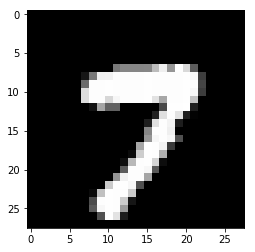

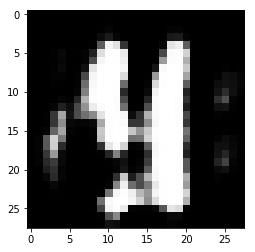

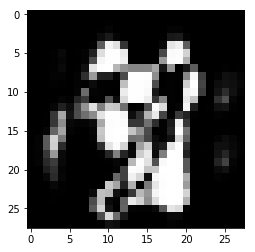

0.0715637 0.187878
0.187878 0.0715636
0.1037 0.0268723
0.0906749 0.0212621
0.0739645 0.0231796
0.0606666 0.0174311
0.0544404 0.0157146
0.0488374 0.015432
0.0458341 0.0108461
0.0439666 0.0107116
0.0420915 0.0115375


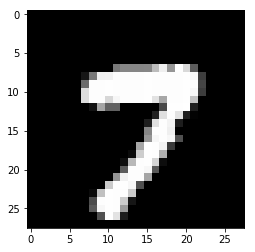

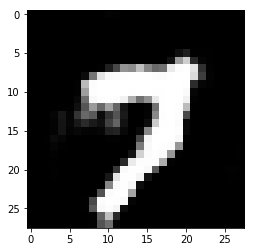

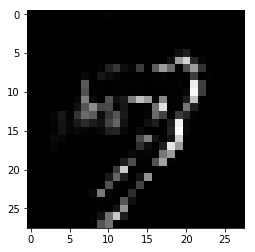

0.0103497 0.0405962


In [16]:
im = my_mnist_test_batch(1, number = 7) 
plt.imshow(np.reshape(im,(28, 28)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([img_z]) 
plt.imshow(np.reshape(im_fake,(28, 28)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(28, 28)) - np.reshape(im,(28, 28)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

fea_loss, res_loss = sess.run([discrimination_loss,residual_loss], {ano_y : np.reshape(im,(1,28, 28,1))})

print(fea_loss, res_loss)


for i in range(1000) :
    _ , loss1, loss2 = sess.run([mapping_optim,residual_loss,discrimination_loss], {ano_y : np.reshape(im,(1,28, 28,1))})
    if  i % 100 == 0 : 
        print(loss1,loss2)
        
        
plt.imshow(np.reshape(im,(28, 28)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([img_z]) 
plt.imshow(np.reshape(im_fake,(28, 28)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(28, 28)) - np.reshape(im,(28, 28)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

fea_loss, res_loss = sess.run([discrimination_loss,residual_loss], {ano_y : np.reshape(im,(1,28, 28,1))})

print(fea_loss, res_loss)

In [17]:


if not os.path.isdir(file_name) :
    os.mkdir(file_name)

    
sess = tf.InteractiveSession()
    
new_saver = tf.train.import_meta_graph(file_name + '/para.cktp.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(file_name + '/'))


z = sess.graph.get_tensor_by_name("z:0")
u = sess.graph.get_tensor_by_name("u:0")

ano_y = sess.graph.get_tensor_by_name("ano_y:0")
ano_z = sess.graph.get_tensor_by_name("ano_z:0")

isTrain = sess.graph.get_tensor_by_name("isTrain:0")

    
G_z = sess.graph.get_tensor_by_name("G_z:0")
img_z = sess.graph.get_tensor_by_name("img_z:0")


#feature_loss = sess.graph.get_tensor_by_name("feature_loss:0")
D_real_loss = sess.graph.get_tensor_by_name('D_real_loss:0')
D_fake_loss = sess.graph.get_tensor_by_name('D_fake_loss:0')

D_loss = sess.graph.get_tensor_by_name("D_loss:0")
G_loss = sess.graph.get_tensor_by_name("G_loss:0")
residual_loss = sess.graph.get_tensor_by_name("residual_loss:0")
discrimination_loss = sess.graph.get_tensor_by_name("discrimination_loss:0")

D_optim = sess.graph.get_operation_by_name("D_optim")
G_optim = sess.graph.get_operation_by_name("G_optim")

mapping_optim = sess.graph.get_operation_by_name("mapping_optim")






INFO:tensorflow:Restoring parameters from ex_anoGANs_2/para.cktp


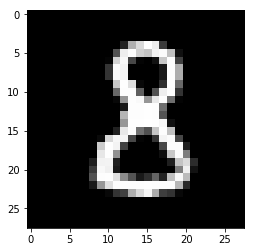

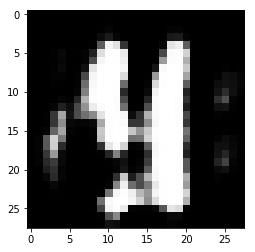

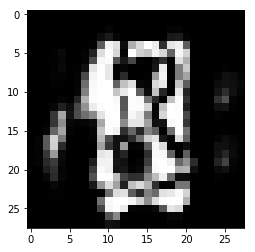

0.0715635 0.198473
0.198473 0.0715634
0.1516 0.0318197
0.131985 0.0193783
0.120632 0.0211105
0.106106 0.0181268
0.0975743 0.0151035
0.0885614 0.00637911
0.0853161 0.00900574
0.0838573 0.00944044
0.0817891 0.0108573


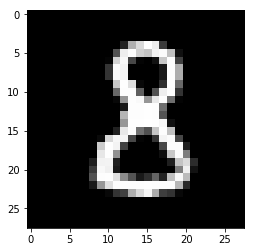

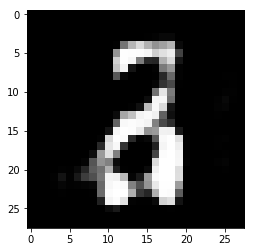

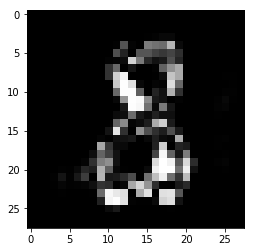

0.011033 0.0805347


In [18]:
im = my_mnist_test_batch(1, number = 8) 
plt.imshow(np.reshape(im,(28, 28)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([img_z]) 
plt.imshow(np.reshape(im_fake,(28, 28)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(28, 28)) - np.reshape(im,(28, 28)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

fea_loss, res_loss = sess.run([discrimination_loss,residual_loss], {ano_y : np.reshape(im,(1,28, 28,1))})

print(fea_loss, res_loss)


for i in range(1000) :
    _ , loss1, loss2 = sess.run([mapping_optim,residual_loss,discrimination_loss], {ano_y : np.reshape(im,(1,28, 28,1))})
    if  i % 100 == 0 : 
        print(loss1,loss2)
        
        
plt.imshow(np.reshape(im,(28, 28)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([img_z]) 
plt.imshow(np.reshape(im_fake,(28, 28)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(28, 28)) - np.reshape(im,(28, 28)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

fea_loss, res_loss = sess.run([discrimination_loss,residual_loss], {ano_y : np.reshape(im,(1,28, 28,1))})

print(fea_loss, res_loss)

In [19]:


if not os.path.isdir(file_name) :
    os.mkdir(file_name)

    
sess = tf.InteractiveSession()
    
new_saver = tf.train.import_meta_graph(file_name + '/para.cktp.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(file_name + '/'))


z = sess.graph.get_tensor_by_name("z:0")
u = sess.graph.get_tensor_by_name("u:0")

ano_y = sess.graph.get_tensor_by_name("ano_y:0")
ano_z = sess.graph.get_tensor_by_name("ano_z:0")

isTrain = sess.graph.get_tensor_by_name("isTrain:0")

    
G_z = sess.graph.get_tensor_by_name("G_z:0")
img_z = sess.graph.get_tensor_by_name("img_z:0")


#feature_loss = sess.graph.get_tensor_by_name("feature_loss:0")
D_real_loss = sess.graph.get_tensor_by_name('D_real_loss:0')
D_fake_loss = sess.graph.get_tensor_by_name('D_fake_loss:0')

D_loss = sess.graph.get_tensor_by_name("D_loss:0")
G_loss = sess.graph.get_tensor_by_name("G_loss:0")
residual_loss = sess.graph.get_tensor_by_name("residual_loss:0")
discrimination_loss = sess.graph.get_tensor_by_name("discrimination_loss:0")

D_optim = sess.graph.get_operation_by_name("D_optim")
G_optim = sess.graph.get_operation_by_name("G_optim")

mapping_optim = sess.graph.get_operation_by_name("mapping_optim")






INFO:tensorflow:Restoring parameters from ex_anoGANs_2/para.cktp


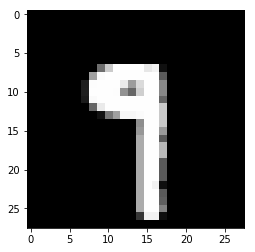

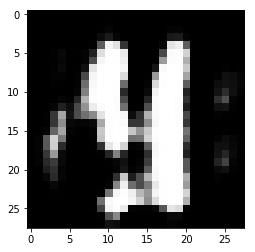

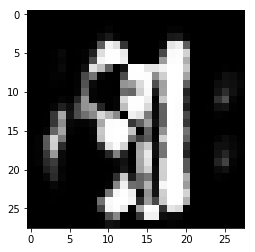

0.0715635 0.199908
0.199908 0.0715635
0.0792757 0.0537966
0.0635884 0.0863681
0.0578935 0.0816207
0.0537526 0.0918374
0.0523916 0.0833816
0.0508837 0.0819603
0.050006 0.0774125
0.0490236 0.0759327
0.0483721 0.0703703


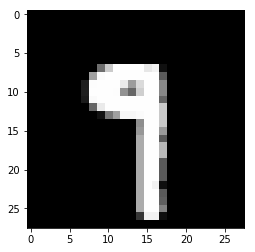

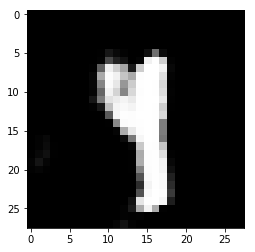

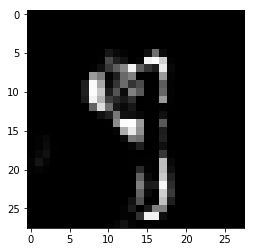

0.067176 0.0474131


In [20]:
im = my_mnist_test_batch(1, number = 9) 
plt.imshow(np.reshape(im,(28, 28)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([img_z]) 
plt.imshow(np.reshape(im_fake,(28, 28)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(28, 28)) - np.reshape(im,(28, 28)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

fea_loss, res_loss = sess.run([discrimination_loss,residual_loss], {ano_y : np.reshape(im,(1,28, 28,1))})

print(fea_loss, res_loss)


for i in range(1000) :
    _ , loss1, loss2 = sess.run([mapping_optim,residual_loss,discrimination_loss], {ano_y : np.reshape(im,(1,28, 28,1))})
    if  i % 100 == 0 : 
        print(loss1,loss2)
        
        
plt.imshow(np.reshape(im,(28, 28)), cmap='Greys_r')
plt.show()
    

im_fake = sess.run([img_z]) 
plt.imshow(np.reshape(im_fake,(28, 28)), cmap='Greys_r')
plt.show()

ano_gap  = np.abs(np.reshape(im_fake,(28, 28)) - np.reshape(im,(28, 28)))
plt.imshow(ano_gap, cmap='Greys_r')
plt.show()  

fea_loss, res_loss = sess.run([discrimination_loss,residual_loss], {ano_y : np.reshape(im,(1,28, 28,1))})

print(fea_loss, res_loss)